# Classifying using a perceptron

In this example, we will build a perceptron to learn a classification between positive and negative numbers.

The problem is summarised as:

**number -> perceptron -> is it positive? yes (1) / no (0)**

This is trivial but we will be able to see the code so we are familiar for more complex problems later-on.

### Set-up (installing and importing)

In [58]:
!pip install jax flax numpy matplotlib

import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax

import numpy as np
import matplotlib.pyplot as plt

### Download data

In [59]:
!wget -O x.txt https://github.com/s-sd/EMS741/raw/refs/heads/main/tutorials/intro_to_dl_example/x.txt
!wget -O y.txt https://github.com/s-sd/EMS741/raw/refs/heads/main/tutorials/intro_to_dl_example/y.txt

--2026-02-04 14:44:13--  https://github.com/s-sd/EMS741/raw/refs/heads/main/tutorials/intro_to_dl_example/x.txt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/s-sd/EMS741/refs/heads/main/tutorials/intro_to_dl_example/x.txt [following]
--2026-02-04 14:44:13--  https://raw.githubusercontent.com/s-sd/EMS741/refs/heads/main/tutorials/intro_to_dl_example/x.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25481 (25K) [text/plain]
Saving to: ‘x.txt’

x.txt               100%[===================>]  24.88K  --.-KB/s    in 0.002s  

2026-02-04 14:44:13 (11.9 MB/s) - ‘x.txt’ saved [25481/25481]

--2026

### Check the data

In [60]:
!ls

sample_data  x.txt  y.txt


In [61]:
x = np.loadtxt('x.txt')
y = np.loadtxt('y.txt')

In [62]:
print('X shape: ', np.shape(x))
print('Y shape: ', np.shape(y))

print('\n')
print('X min: ', np.amin(x))
print('X max: ', np.amax(x))

print('\n')
print('Y min: ', np.amin(y))
print('Y max: ', np.amax(y))
print('\n')


# plot some samples
sample_indexes = np.random.randint(0, len(y), 16)

x_samples = x[sample_indexes]
y_samples = y[sample_indexes]

for i in range(len(x_samples)):
  print('Input: ', x_samples[i], ', Label: ', y_samples[i])

X shape:  (1000,)
Y shape:  (1000,)


X min:  -1996.0
X max:  1996.0


Y min:  0.0
Y max:  1.0


Input:  -907.0 , Label:  0.0
Input:  1141.0 , Label:  1.0
Input:  229.0 , Label:  1.0
Input:  1535.0 , Label:  1.0
Input:  80.0 , Label:  1.0
Input:  -1503.0 , Label:  0.0
Input:  -636.0 , Label:  0.0
Input:  -1484.0 , Label:  0.0
Input:  -1483.0 , Label:  0.0
Input:  1908.0 , Label:  1.0
Input:  1404.0 , Label:  1.0
Input:  -367.0 , Label:  0.0
Input:  969.0 , Label:  1.0
Input:  1197.0 , Label:  1.0
Input:  1221.0 , Label:  1.0
Input:  80.0 , Label:  1.0


In [63]:
# now let's squish/ normalise the x values to between 0 to 1 assuming min, max of -2000, +2000
# this helps tokeep the weights stable during leanring

min_x = -2000
max_x = 2000

x_normalised = (x - min_x) / (max_x - min_x)

print('\n')
print('X_normalised min: ', np.amin(x_normalised))
print('X_normalised max: ', np.amax(x_normalised))




X_normalised min:  0.001
X_normalised max:  0.999


### Split the data into relevant sets

In [64]:
# Shuffle the data randomly
indexes = np.random.permutation(len(x))
x_final = x_normalised[indexes]
y_final = y[indexes]

# split into train, val and test sets
train_val_test_ratio = [0.6, 0.2, 0.2]

train_index_start = 0
train_index_end = int(train_val_test_ratio[0] * len(x))

val_index_start = train_index_end
val_index_end = val_index_start + int(train_val_test_ratio[1] * len(x))

test_index_start = val_index_end
test_index_end = test_index_start + int(train_val_test_ratio[2] * len(x))


x_train, y_train = x_final[train_index_start:train_index_end], y_final[train_index_start:train_index_end]

x_val, y_val = x_final[val_index_start:val_index_end], y_final[val_index_start:val_index_end]

x_test, y_test = x_final[test_index_start:test_index_end], y_final[test_index_start:test_index_end]


print("Train:", x_train.shape, y_train.shape)
print("Val:", x_val.shape, y_val.shape)
print("Test: ", x_test.shape,  y_test.shape)


Train: (600,) (600,)
Val: (200,) (200,)
Test:  (200,) (200,)


### Build a perceptron

y = f(x; w)

Where we apply non-linear activation to the element-wise multiplication of w and x, which is a single perceptron. Note that the bias term is added automatically.

In [65]:
# jax requires an extra dimension (e.g., shape (batch, 1))
# convert all data accordingly

def to_jax_2d(x, y):
    x = jnp.asarray(x, dtype=jnp.float32).reshape(-1, 1)
    y = jnp.asarray(y, dtype=jnp.float32).reshape(-1, 1)
    return x, y

x_train_j, y_train_j = to_jax_2d(x_train, y_train)
x_val_j,   y_val_j   = to_jax_2d(x_val,   y_val)
x_test_j,  y_test_j  = to_jax_2d(x_test,  y_test)

In [66]:
# now we can define the perceptron
class Perceptron(nn.Module):
    @nn.compact
    def __call__(self, x):
        logits = nn.Dense(1, name="dense")(x)      # single unit
        probs  = nn.sigmoid(logits)                # sigmoid
        return probs

# build the loss
def bce_loss(probs, targets, eps=1e-7):
    # probs, targets: (B, 1)
    probs = jnp.clip(probs, eps, 1.0 - eps)
    return -jnp.mean(targets * jnp.log(probs) + (1.0 - targets) * jnp.log(1.0 - probs))

# build the optimiser
def create_state(rng, learning_rate=0.01):
    model = Perceptron()
    params = model.init(rng, jnp.ones((1, 1), dtype=jnp.float32))["params"]
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)


In [67]:
# now we need a training loop

def train_step(state, x, y):
    def loss_fn(params):
        probs = state.apply_fn({"params": params}, x)
        return bce_loss(probs, y)

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def eval_loss(state, x, y):
    probs = state.apply_fn({"params": state.params}, x)
    return bce_loss(probs, y), probs

rng = jax.random.PRNGKey(0)
state = create_state(rng, learning_rate=0.1)


epochs = 10
batch_size = 16

train_losses = []
val_losses = []

N = int(x_train_j.shape[0])

for epoch in range(epochs):

    # Shuffle using NumPy
    perm = np.random.permutation(N)

    epoch_loss = 0.0
    for i in range(0, N, batch_size):
        idx = perm[i:i+batch_size]
        xb = x_train_j[idx]
        yb = y_train_j[idx]

        state, loss = train_step(state, xb, yb)
        epoch_loss += float(loss) * xb.shape[0]

    epoch_loss /= N
    train_losses.append(epoch_loss)

    vloss, _ = eval_loss(state, x_val_j, y_val_j)
    vloss = float(vloss)
    val_losses.append(vloss)

    print(f"Epoch {epoch+1:02d}/{epochs} | train loss: {epoch_loss:.4f} | val loss: {vloss:.4f}")

Epoch 01/10 | train loss: 0.4692 | val loss: 0.3416
Epoch 02/10 | train loss: 0.3104 | val loss: 0.2433
Epoch 03/10 | train loss: 0.2384 | val loss: 0.1900
Epoch 04/10 | train loss: 0.2001 | val loss: 0.1625
Epoch 05/10 | train loss: 0.1754 | val loss: 0.1410
Epoch 06/10 | train loss: 0.1577 | val loss: 0.1290
Epoch 07/10 | train loss: 0.1454 | val loss: 0.1142
Epoch 08/10 | train loss: 0.1358 | val loss: 0.1052
Epoch 09/10 | train loss: 0.1269 | val loss: 0.1045
Epoch 10/10 | train loss: 0.1193 | val loss: 0.0936


### Plotting losses

Text(0, 0.5, 'loss')

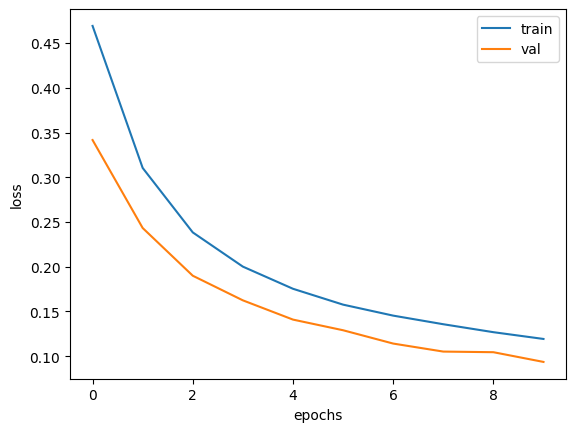

In [68]:
plt.plot(train_losses)
plt.plot(val_losses)

plt.legend(['train', 'val'])
plt.xlabel('epochs')
plt.ylabel('loss')

### Evalute the model

In [69]:
test_loss, test_probs = eval_loss(state, x_test_j, y_test_j)
test_preds = (test_probs > 0.5).astype(jnp.float32)
test_acc = float(jnp.mean(test_preds == y_test_j))

print(f"Test accuracy: {test_acc:.3f}")


# Extract weights and bias from Flax params
# params structure: {'dense': {'kernel': (1,1), 'bias': (1,)}}
w = state.params["dense"]["kernel"]  # shape (1,1)
b = state.params["dense"]["bias"]    # shape (1,)


print("Learned weight:", float(w[0, 0]))
print("Learned bias:  ", float(b[0]))

Test accuracy: 1.000
Learned weight: 13.598987579345703
Learned bias:   -6.781042575836182
